<img src="../img/iris.jpg"  width="450" height="200">

### Understanding Mutliclass Classificaion ML Models with SHAP

The iris dataset is famous in the data science community; you can learn more [here](https://archive.ics.uci.edu/ml/datasets/iris). 

What we need to know is that 

- the dataset is made up of 150 rows/ instances
- Each row has four attribue features relating to different dimensions (width and length of sepal and petals)
- there are three species (classes) to consider: Setosa, Versicolour, Virginica. 
    - These are the targets and there are 50 observations for each species - therefore we can say the data is balanced.

In this exercise you will need go through the code and fill in any missing spaces. There will be clues and hints.

By the end of this exercise you should know 
- how to calculate feature importance in two ways for tree-based models
- how to create PDP and ICE plots for any model 
- how to use the SHAP library to understand a tree-based model

#### Library Imports

In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay


import shap
from shap import Explanation

# Java Script for SHAP Plots
shap.initjs()

In [6]:
# Helper function to see methods in object
# Might be useful when working through this exercise

def object_methods(obj):
    '''
    Helper function to list methods associated with an object
    '''
    try:
        methods = [method_name for method_name in dir(obj)
                   if callable(getattr(obj, method_name))]
        print('Below are the methods for object: ', obj)
        for method in methods:
            print(method)
    except:
        print("Error")

#### Load & Clean Data

Run this cell to load the dataframe from sklearns example datasets.

In [7]:
# Loading and cleaning the data
iris = datasets.load_iris()

# made into dataframe
iris = pd.DataFrame(
    data= np.c_[iris['data'], iris['target']],
    columns= iris['feature_names'] + ['target']
    )

Examine the dataset with your choice of function. 

Convert the 'target' column from a float into an integer.

In [9]:
iris['target'] = iris['target'].apply(lambda x: int(x))

iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Run the code below to convert the classes 0, 1 and 2 into the relevant species names and add this as a new column.  

Try to understand how this is working - it's a useful little pattern to know for your own datasets!

In [10]:
# Define the different classes/ species
class_dict = {0 : 'setosa',
             1 : 'versicolor',
             2 : 'virginica'}

class_dict

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [12]:
# Add species into the dataframe and view a random sample of 10 rows
iris['species'] = iris['target'].apply(lambda x: class_dict.get(x))

iris.sample(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
109,7.2,3.6,6.1,2.5,2,virginica
117,7.7,3.8,6.7,2.2,2,virginica
22,4.6,3.6,1.0,0.2,0,setosa
6,4.6,3.4,1.4,0.3,0,setosa
32,5.2,4.1,1.5,0.1,0,setosa
64,5.6,2.9,3.6,1.3,1,versicolor
71,6.1,2.8,4.0,1.3,1,versicolor
79,5.7,2.6,3.5,1.0,1,versicolor
106,4.9,2.5,4.5,1.7,2,virginica
14,5.8,4.0,1.2,0.2,0,setosa


In [13]:
# Take a look at some stats about the data
iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


#### Plot the Data

Before we go any further, let's plot the iris dataset to see how the petal width and length relate to the  

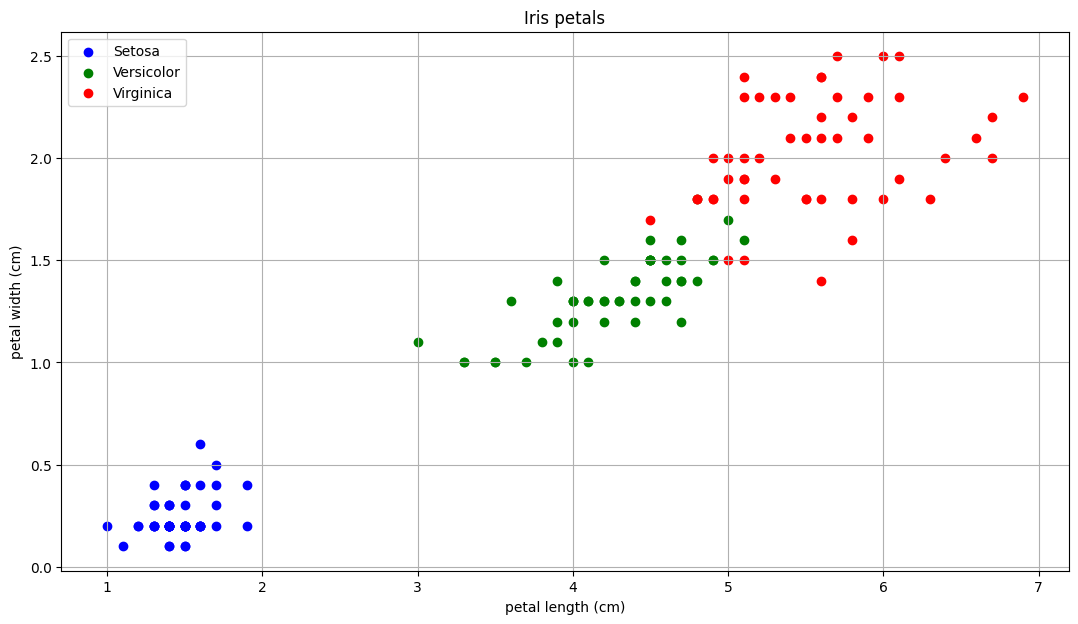

In [15]:
setosa = iris[iris.species == "setosa"]
versicolor = iris[iris.species=='versicolor']
virginica = iris[iris.species=='virginica']

fig, ax = plt.subplots()
fig.set_size_inches(13, 7) # adjusting the length and width of plot

# lables and scatter points
ax.scatter(setosa['petal length (cm)'], setosa['petal width (cm)'], label="Setosa", facecolor="blue")
ax.scatter(versicolor['petal length (cm)'], versicolor['petal width (cm)'], label="Versicolor", facecolor="green")
ax.scatter(virginica['petal length (cm)'], virginica['petal width (cm)'], label="Virginica", facecolor="red")


ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")
ax.grid()
ax.set_title("Iris petals")
ax.legend()

#### Performing Classification

In [18]:
# Droping the target and species since we only need the measurements
X = iris.drop(['target','species'], axis=1)

# Define features (X) and target (y)
X = X
y = iris['target']

# get class and features names
class_names = iris.species.unique()
feature_names = X.columns

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Instantiate a RFC model and fit it
model = RandomForestClassifier(n_estimators=100,
                               n_jobs=-1,
                               class_weight='balanced',
                               random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

#### Feature Importance

### Look at feature importance using the feature_importances_ attribute

In [21]:
# Looking at standard feature importance
importances = model.feature_importances_
importances

array([0.1127023 , 0.02950201, 0.4369339 , 0.42086178])

### Mean decrease in impurity

Generate a plot of the MDI feature importances.

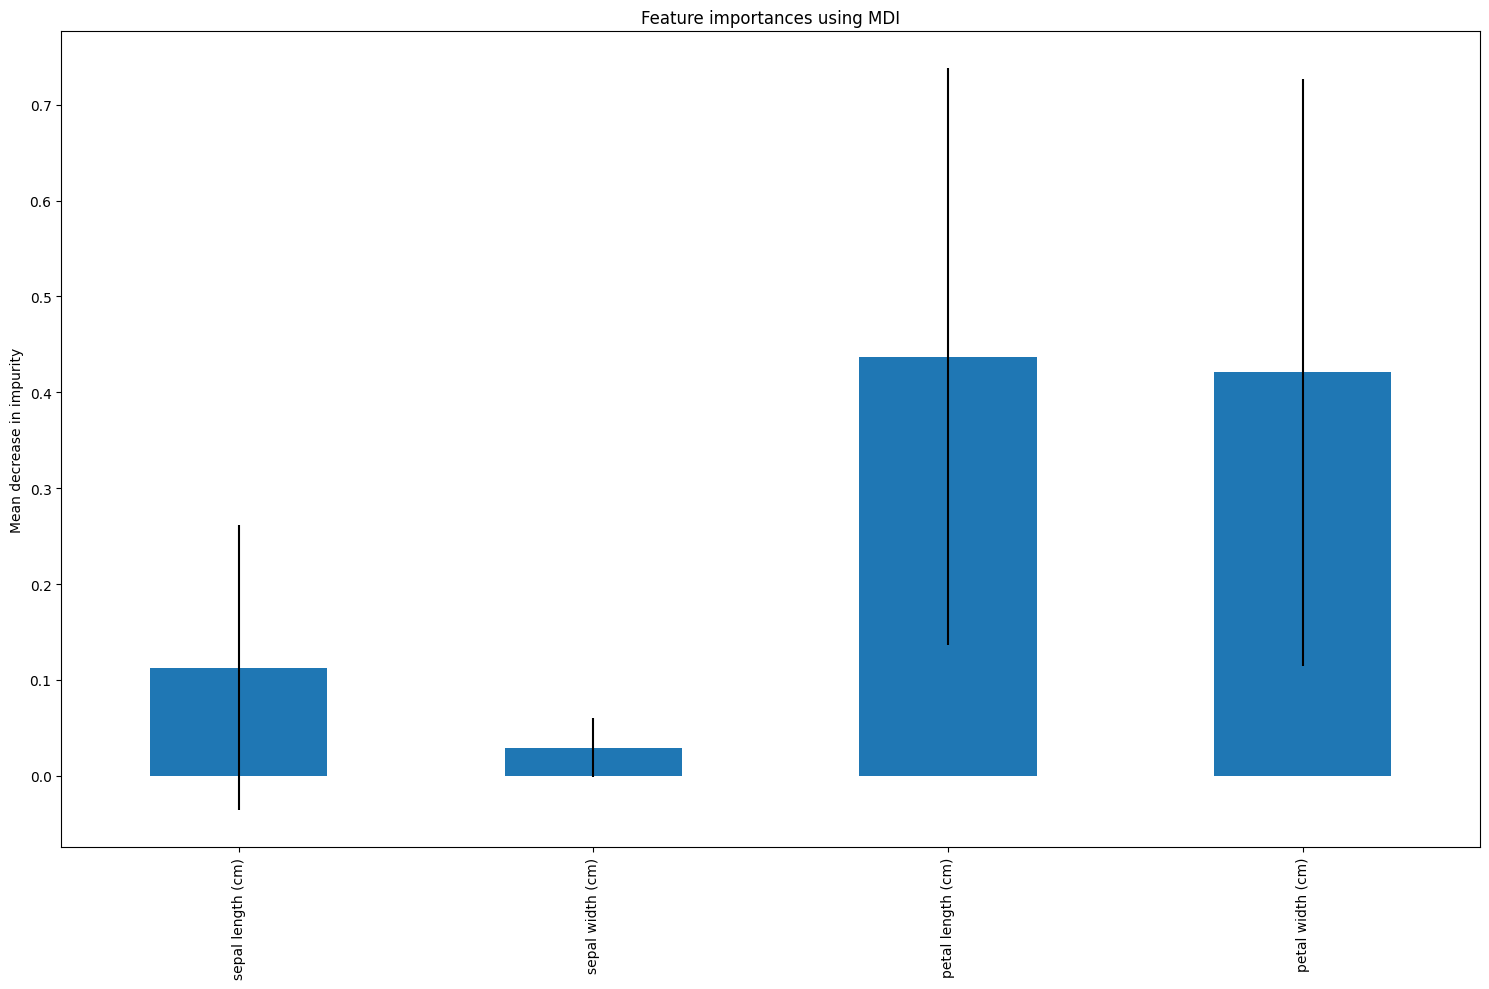

In [22]:
feature_names = X.columns.tolist()

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Permutation Feature Importance

Calculate permutation feature importance for this dataset and plot it.

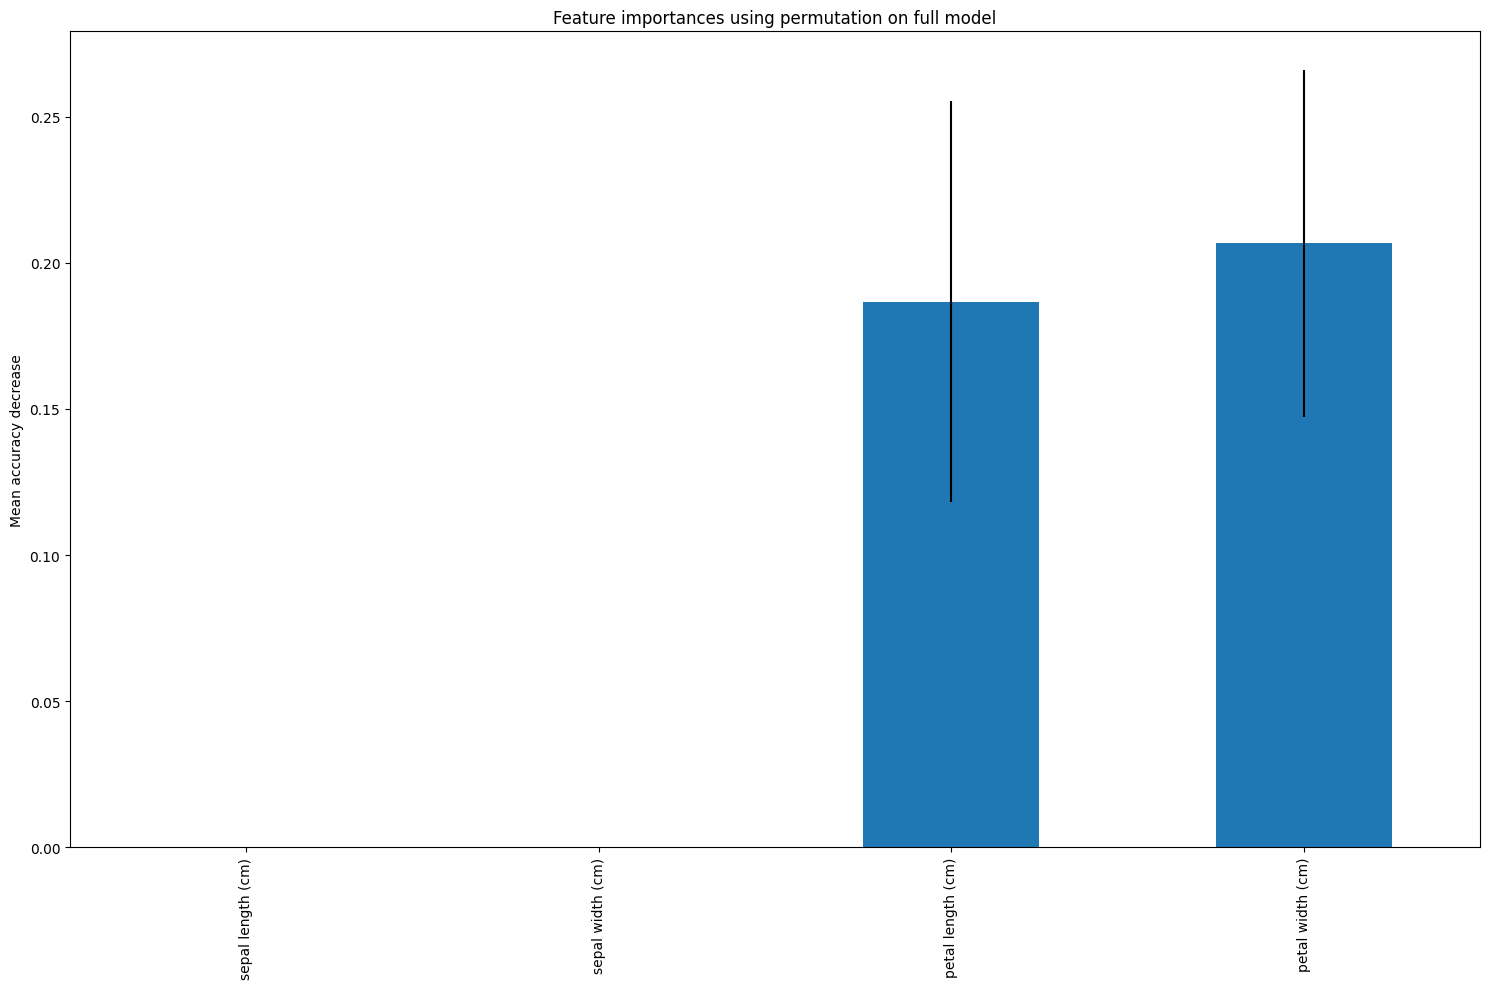

In [24]:
# Permutation feature importance
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### Predictions

Use the model to make predictions for the training and test set

In [25]:
# Training predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#### Assessing Performance

Run this code to generate metrics for the training and test performance of this model.

Run this code to generate a confusion matrix for this model.

## PDP Plots

In [84]:
X_test

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
73,6.1,2.8,4.7,1.2
18,5.7,3.8,1.7,0.3
118,7.7,2.6,6.9,2.3
78,6.0,2.9,4.5,1.5
76,6.8,2.8,4.8,1.4
31,5.4,3.4,1.5,0.4
64,5.6,2.9,3.6,1.3
141,6.9,3.1,5.1,2.3
68,6.2,2.2,4.5,1.5
82,5.8,2.7,3.9,1.2


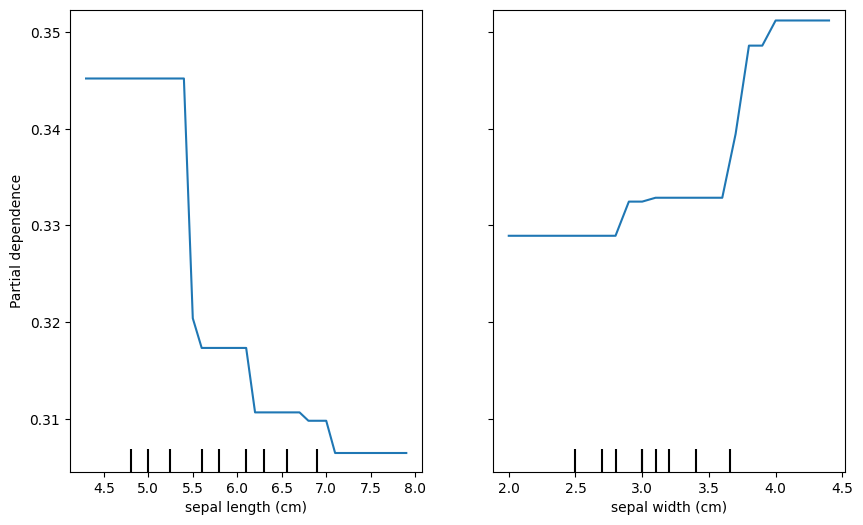

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X,  # Your feature matrix
    features=['sepal length (cm)', 'sepal width (cm)'],  # List of features to plot
    target=0,
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

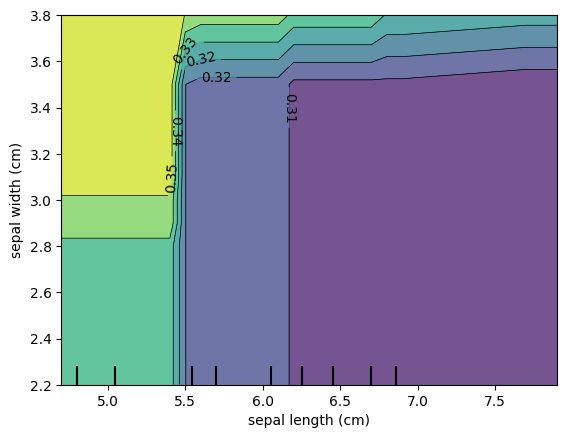

In [106]:
PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    features=[('sepal length (cm)', 'sepal width (cm)')],
    kind='average',
    target=0,
    random_state=0
)

## ICE Plots

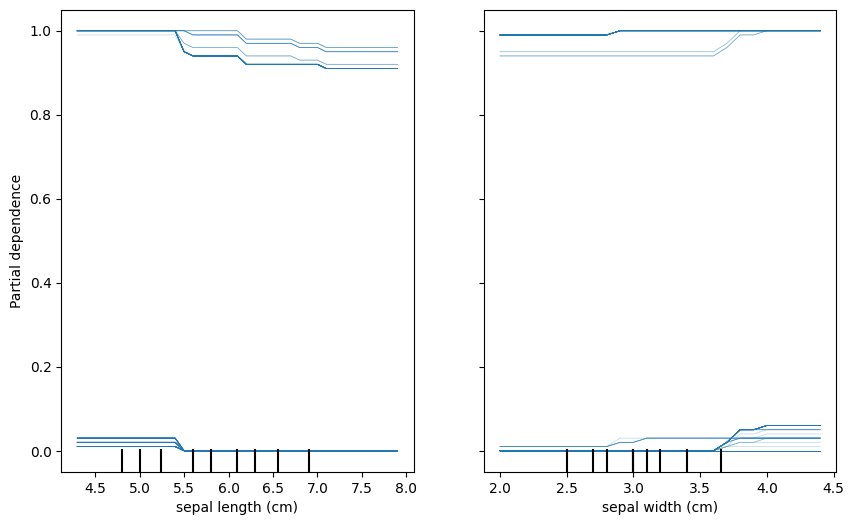

In [108]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X,  # Your feature matrix
    features=['sepal length (cm)', 'sepal width (cm)'],  # List of features to plot
    target=0,
    # subsample=10,
    kind='individual',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

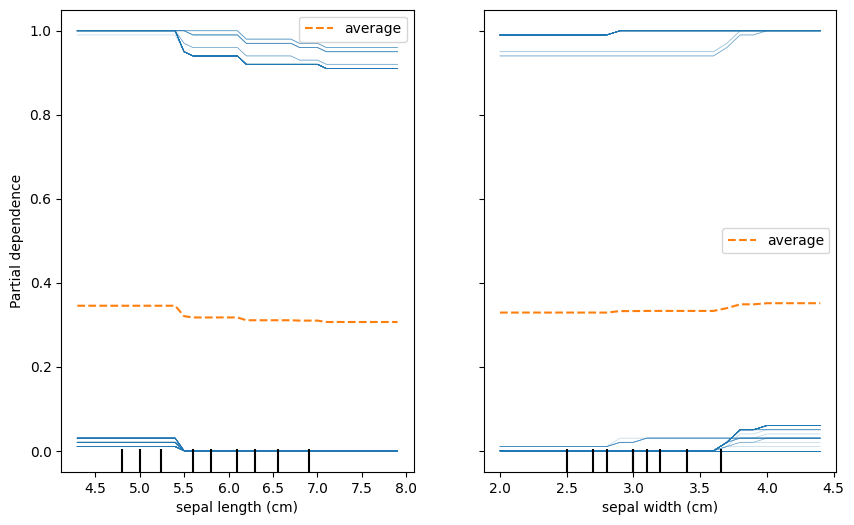

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X,  # Your feature matrix
    features=['sepal length (cm)', 'sepal width (cm)'],  # List of features to plot
    target=0,
    # subsample=10,
    kind='both',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

## SHAP

### Obtaining Shap Values

There is ONE missing value in the section below.

HINT Why not use the `object_methods` function to see if you can identify which method will return Shapley Values

Generate a SHAP explainer.

In [28]:
# Compute SHAP values
explainer = shap.Explainer(model)

Run the `object_methods` function on this to see what methods are available.

Try to identify which method will return Shapley values.

In [29]:
object_methods(explainer)

Below are the methods for object:  <shap.explainers._tree.TreeExplainer object at 0x000001E0A53900D0>
_TreeExplainer__dynamic_expected_value
__call__
__class__
__delattr__
__dir__
__eq__
__format__
__ge__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__sizeof__
__str__
__subclasshook__
_compute_main_effects
_get_shap_interactions_output
_get_shap_output
_instantiated_load
_validate_inputs
assert_additivity
explain_row
link
load
save
shap_interaction_values
shap_values
supports_model_with_masker


In [30]:
shap_values = explainer.shap_values(X_test)
shap_values

[array([[-3.20722360e-02, -5.74146055e-03, -1.52434611e-01,
         -1.47125435e-01],
        [-3.22217142e-02,  2.93824404e-02,  3.22077065e-01,
          3.33388467e-01],
        [-3.38886378e-02, -3.46440915e-03, -1.53276337e-01,
         -1.46744359e-01],
        [-3.42752934e-02, -3.36116257e-03, -1.52291158e-01,
         -1.47446129e-01],
        [-3.35009518e-02, -4.75892807e-03, -1.52731771e-01,
         -1.46382091e-01],
        [ 7.70102549e-02,  7.77023324e-04,  2.89887815e-01,
          2.94951164e-01],
        [-3.40951086e-02, -3.36116257e-03, -1.52792036e-01,
         -1.47125435e-01],
        [-3.72792486e-02, -1.12595581e-04, -1.53211875e-01,
         -1.46770024e-01],
        [-3.29808510e-02, -5.74146055e-03, -1.51339498e-01,
         -1.47311932e-01],
        [-3.20722360e-02, -5.74146055e-03, -1.52434611e-01,
         -1.47125435e-01],
        [-3.71551768e-02, -1.74631475e-04, -1.53211875e-01,
         -1.46832059e-01],
        [ 8.09803192e-02, -4.01219054e-05, 

Generate a SHAP summary plot.

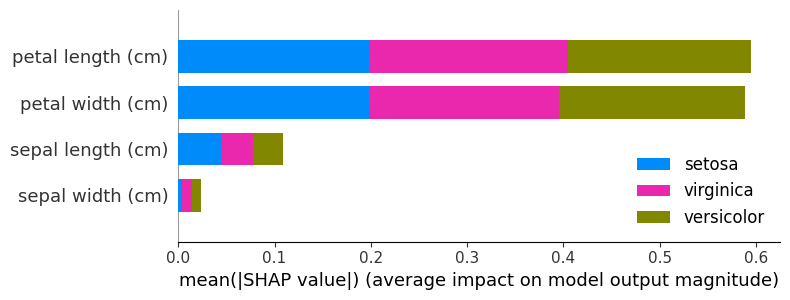

In [31]:
shap.summary_plot(shap_values,
                  X_test.values,
                  plot_type="bar",
                  class_names= class_names,
                  feature_names = feature_names)

#### Summary Plots for each Class

---------

Summary Plot for Class Setosa


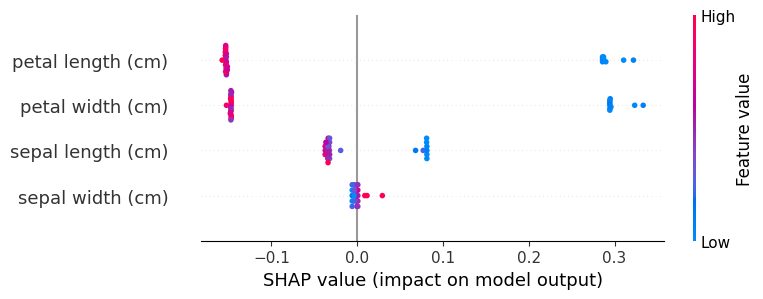

---------

Summary Plot for Class Versicolor


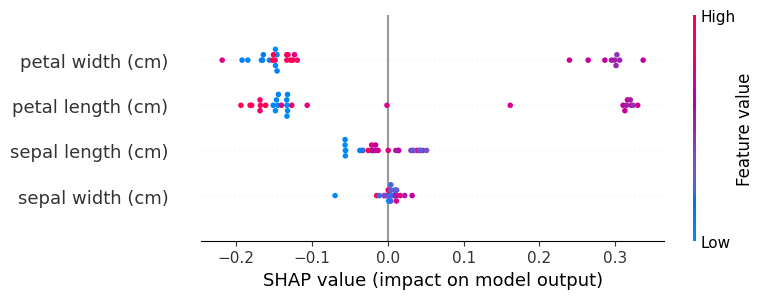

---------

Summary Plot for Class Virginica


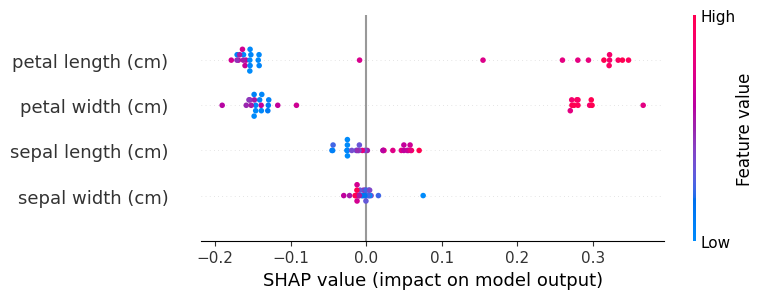

In [32]:
# Summary Plot for Each Class

for class_id in iris.target.unique():
    class_name = class_dict.get(class_id).capitalize()
    print(f"---------\n\nSummary Plot for Class {class_name}")

    shap.summary_plot(shap_values[class_id],
                      X_test.values,
                      feature_names = feature_names)

#### Dependence Plots for each Class (Species)

Let's look at the columns in our dataset and the indices.

In [35]:
# Lets see the features and respective index numbers
for e, i in enumerate(X_test.columns):
    print(f"{e} - {i}")

0 - sepal length (cm)
1 - sepal width (cm)
2 - petal length (cm)
3 - petal width (cm)


First, generate a dependence plot for the petal length.

Now let's iterate through and create dependence plots per column.

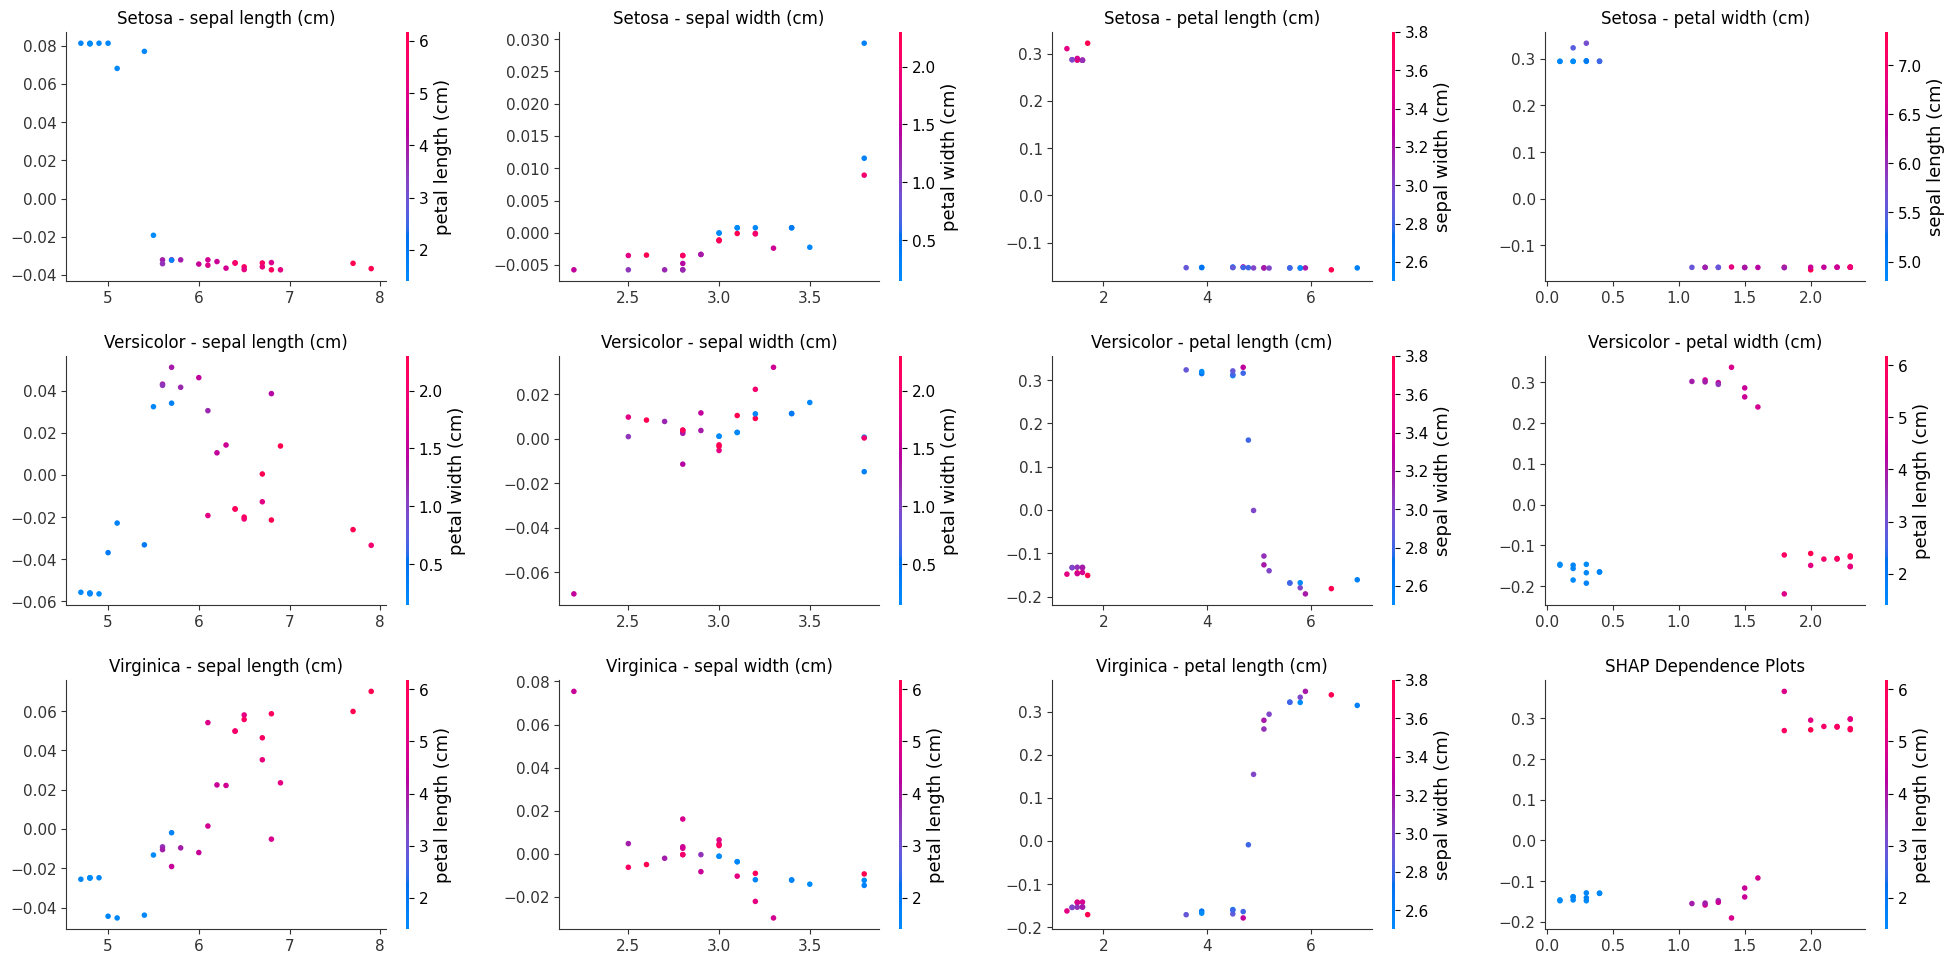

In [67]:
# dependence plots
fig, ax = plt.subplots(3,4, figsize=(20,10))
ax = ax.ravel()
i = 0

for class_id in iris.target.unique():
    for idx, col_name in enumerate(feature_names):
        class_name = class_dict.get(class_id).capitalize()

        shap.dependence_plot(idx, # Index of Column ####
                                shap_values[class_id], # Shap values for class of interest
                                X_test.values, # Array of data
                                feature_names=feature_names,# Feature Names
                                ax=ax[i],
                                show=False)
        ax[i].set_title(f"{class_name} - {col_name}")
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        i+=1
ax = plt.title("SHAP Dependence Plots")


#### Force & Water  Plots

You can change the `row` and `class_id` values below to see the different outputs

In [68]:
# Force Plot
row = 2
class_id = 0

class_name = class_dict.get(class_id).capitalize()

print(f"Below is the Force Plot for {class_name} - Record {row}")
print("i.e. This represents how the probabilty of this class being chosen was made")
shap.force_plot(explainer.expected_value[class_id], # return the base or expected values from the `explainer` object
                shap_values[class_id][row], # return the shap values for the respective class and row number
                X_test.iloc[row].values, # values under the bar
                feature_names = feature_names)


Below is the Force Plot for Setosa - Record 2
i.e. This represents how the probabilty of this class being chosen was made


Create a waterfall plot for a single class instance and row.

In [82]:
row = 5
class_id = 1


Below is the Waterfall Plot for Setosa - Record 5
i.e. This represents how the probabilty of this class being chosen was made


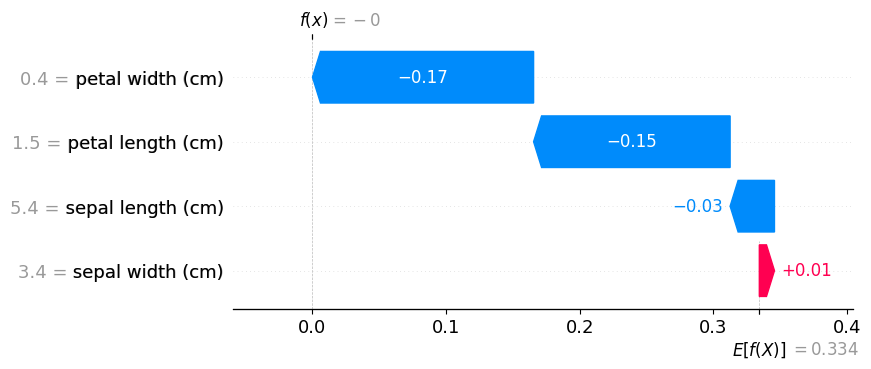

In [83]:
# Waterfall Plot
print(f"Below is the Waterfall Plot for {class_name} - Record {row}")
print("i.e. This represents how the probabilty of this class being chosen was made")
shap.waterfall_plot(shap.Explanation(values = shap_values[class_id][row], # return the shap values for the respective class and row number
                                     base_values = explainer.expected_value[class_id], # return the base or expected values from the `explainer` object
                                     data = X_test.iloc[row], # feature values (light grey on left hand side) ####
                                     feature_names = feature_names))